In [3]:
import sys
import os
from pathlib import Path

scripts_dir = Path().resolve()
parent_dir = scripts_dir.parent
sys.path.insert(0, str(parent_dir))

import aeon
import aeon.io.api as api
from aeon.io import reader, video
from aeon.schema.dataset import exp02
from aeon.analysis.utils import visits, distancetravelled

import SSM
from SSM.ssm.plots import gradient_cmap, white_to_color_cmap

import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, SecondLocator, DateFormatter

import numpy as np
import pandas as pd
import seaborn as sns

import scipy
import pyarrow

import torch

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import pymc3 as pm

import Functions.inference as inference
import Functions.kinematics as kinematics
import Functions.learning as learning

!ls /ceph/aeon

# Long, individual session
root = [Path("/ceph/aeon/aeon/data/raw/AEON2/experiment0.2")]

# Ensure root exists
if not np.all([path.exists() for path in root]):
    print("Cannot find root paths. Check path names or connection.")
    
Exp02Summary = api.load(root, exp02.Metadata).metadata[0].toDict()
Patch_Pos = [device['Regions']['ArrayOfPoint'] for device in Exp02Summary['Devices'] if device['Name'].startswith('ActivityPatch')]

subject_events = api.load(root, exp02.ExperimentalMetadata.SubjectState)
sessions = visits(subject_events[subject_events.id.str.startswith("BAA-")])

short_sessions = sessions.iloc[[4,16,17,20,23,24,25,26,28,29,30,31]]
long_sessions = sessions.iloc[[8, 10, 11, 14]]

aeon			 aeon_transfer.log  rmhzbm0  test2
aeon_transfer_final.log  db_dumps	    test


In [3]:
display(short_sessions)

,id,weight_enter,weight_exit,enter,exit,duration
4,BAA-1100700,26.3,26.3,2022-03-15 12:40:36.282139778,2022-03-15 15:56:55.801119804,0 days 03:16:19.518980026
16,BAA-1101818,26.2,26.7,2022-06-21 10:27:42.615139961,2022-06-21 13:15:50.564740181,0 days 02:48:07.949600220
17,BAA-1101819,25.4,26.4,2022-06-21 13:28:10.593659878,2022-06-21 16:34:29.241280079,0 days 03:06:18.647620201
20,BAA-1101818,26.4,28.0,2022-06-23 08:39:04.261089801,2022-06-23 11:14:46.121759892,0 days 02:35:41.860670091
23,BAA-1101818,26.9,27.8,2022-06-24 09:32:37.183360100,2022-06-24 12:29:54.365859985,0 days 02:57:17.182499885
24,BAA-1101823,27.9,27.9,2022-07-14 12:53:15.740799904,2022-07-14 16:35:05.846270084,0 days 03:41:50.105470180
25,BAA-1101821,25.0,26.0,2022-07-15 13:14:40.239679813,2022-07-15 15:47:44.568860054,0 days 02:33:04.329180241
26,BAA-1101819,25.7,27.1,2022-07-19 10:37:08.422299862,2022-07-19 16:04:43.376220226,0 days 05:27:34.953920364
28,BAA-1101818,26.7,29.5,2022-08-15 10:25:01.651199818,2022-08-15 13:04:50.849309921,0 days 02:39:49.198110103
29,BAA-1101819,27.5,30.0,2022-08-15 13:11:23.791259766,2022-08-15 16:10:27.350080013,0 days 02:59:03.558820247


In [4]:
display(long_sessions)

,id,weight_enter,weight_exit,enter,exit,duration
8,BAA-1100699,26.75,29.0,2022-03-29 13:11:37.277699947,2022-04-04 09:16:51.086110115,5 days 20:05:13.808410168
10,BAA-1100701,26.70,30.6,2022-04-04 15:54:07.945059776,2022-04-08 16:34:36.183650017,4 days 00:40:28.238590241
11,BAA-1100699,29.00,28.2,2022-04-20 11:51:24.997630119,2022-04-28 10:02:56.655809879,7 days 22:11:31.658179760
14,BAA-1100702,27.00,28.9,2022-05-03 11:08:12.660739899,2022-05-12 09:21:42.411650181,8 days 22:13:29.750910282


In [6]:
start, end = pd.Timestamp('2022-03-15 12:40:36.282139778'), pd.Timestamp('2022-03-15 15:56:55.801119804')
mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
        
mouse_pos = kinematics.ProcessRawData(mouse_pos, root, start, end)

obs = np.transpose(mouse_pos[["x", "y"]].to_numpy())

In [52]:
def FindValidData(obs, length_lower = 2000, length_upper = 6000):
    nan_indices = np.where(np.isnan(obs[0]))[0]
    non_nan_blocks = nan_indices[1:] - nan_indices[:-1]
    start, end = 0, nan_indices[0] - 1
    for i in range(len(non_nan_blocks)):
        if non_nan_blocks[i] > length_lower and non_nan_blocks[i] < length_upper:
            start = nan_indices[i] + 1
            end = nan_indices[i+1] - 1
                
    return obs[:,start:end]

In [51]:
FindValidData(obs)

(529132, 531874)

In [53]:
#import numpy as np
title = 'ShortSession0'
print(title)
P = np.load('../Data/MouseKinematicParameters/' + title + 'Parameters.npz', allow_pickle=True)
sigma_a, sigma_x, sigma_y, sqrt_diag_V0_value, B, Qe, m0, V0, Z, R = P['sigma_a'].item(), P['sigma_x'].item(), P['sigma_y'].item(), P['sqrt_diag_V0_value'].item(), P['B'], P['Qe'], P['m0'], P['V0'], P['Z'], P['R']
print('sigma_a: ', sigma_a)
print('sqrt_diag_V0: ', sqrt_diag_V0_value)
print(" ")

ShortSession0
sigma_a:  0.07523428648710251
sqrt_diag_V0:  -2.0350071659264986e-08
 


In [54]:
for session, count in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    if count != 0: continue
    title = 'ShortSession'+str(count)
    
    start, end = session.enter, session.exit
    mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
    mouse_pos = kinematics.ProcessRawData(mouse_pos, root, start, end)
    
    kinematics.AddKinematics(title, mouse_pos)

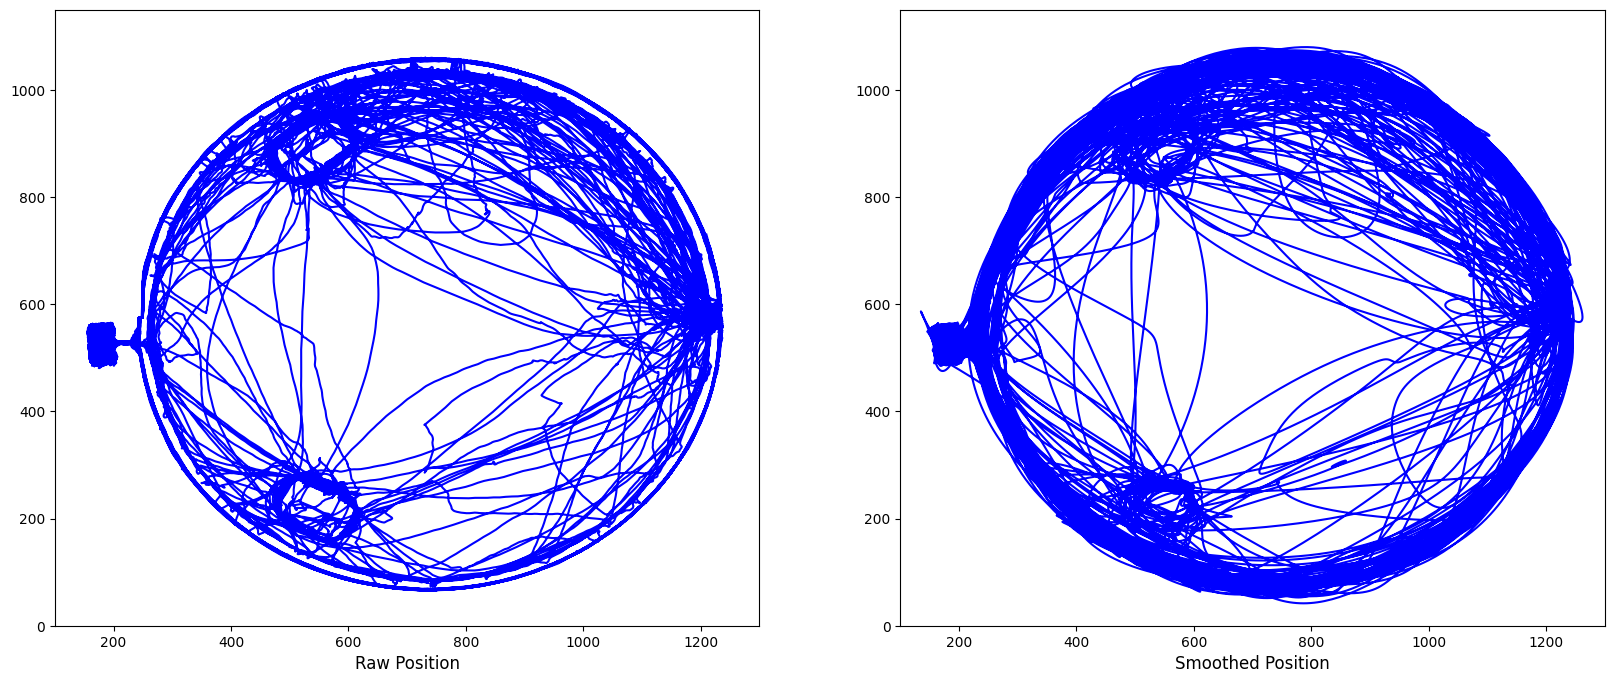

In [66]:
fig, axs = plt.subplots(1,2,figsize = (20, 8))
axs[0].plot(mouse_pos.x, mouse_pos.y, color = 'blue')
axs[1].plot(mouse_pos.smoothed_position_x, mouse_pos.smoothed_position_y, color = 'blue')
axs[0].set_xlabel('Raw Position', fontsize = 12)
axs[1].set_xlabel('Smoothed Position', fontsize = 12)
for i in range(2):
    axs[i].set_xlim(100, 1300)
    axs[i].set_ylim(0, 1150)
plt.show()

In [2]:
def ConcatenateSessions():
    dfs = []
    for session, i in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
        title = 'ShortSession'+str(i)
        print(title)
        Visits_Patch1 = pd.read_parquet('../Data/RegressionPatchVisits/' + title + 'Visit1.parquet', engine='pyarrow')
        Visits_Patch2 = pd.read_parquet('../Data/RegressionPatchVisits/' + title + 'Visit2.parquet', engine='pyarrow')
        dfs.append(Visits_Patch1)
        dfs.append(Visits_Patch2)
        
    VISIT = pd.concat(dfs, ignore_index=False)
    VISIT = VISIT[VISIT['distance'] >= 0.1]
    VISIT['interc'] = 1
    
    return VISIT

def Variables(VISIT, feature, predictor = 'distance'):
    X = VISIT[feature]
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), index = X.index, columns = X.columns)
    X['interc'] = 1
    Y = VISIT[predictor]
    
    return X, Y

In [5]:
VISIT = ConcatenateSessions()
X, Y = Variables(VISIT, feature = ['speed','acceleration', 'weight','PelletsInLastVisitSelf', 'PelletsInLastVisitOther', 'IntervalLastVisit' ,'entry'], predictor='distance')
    

ShortSession0
ShortSession1
ShortSession2
ShortSession3
ShortSession4
ShortSession5
ShortSession6
ShortSession7
ShortSession8
ShortSession9
ShortSession10
ShortSession11


In [14]:
split_size = int(len(Y) * 0.75)
indices = np.arange(len(Y))
    

np.random.shuffle(indices)
        
train_indices = indices[:split_size]
test_indices = indices[split_size:]

X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
Y_train, Y_test = Y.iloc[train_indices], Y.iloc[test_indices]

In [13]:
Y

0      16.534254
1      42.480055
2     173.970176
3     184.388075
4      34.473720
         ...    
44    584.899622
45    289.355583
46    196.835555
47    389.368031
48    201.690900
Name: distance, Length: 425, dtype: float64